In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image 
from sklearn import metrics
import scipy.stats as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skimage.io import imread, imshow
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations, permutations
# from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

In [2]:
covid_path = '/Users/deangao/Desktop/CSM226/covidProject_data/covid/augmented/images/'
norm_path = '/Users/deangao/Desktop/CSM226/covidProject_data/normal/'
pneu_path = '/Users/deangao/Desktop/CSM226/covidProject_data/pneumonia/'

In [3]:
# covid_imgs = []
# for p in os.listdir(covid_path):
# #     img = Image.open(covid_path + 'images/' + p)
#     covid_imgs.append(p)
# #     print(p)

# c_pixels = []
# for c_img in covid_imgs:
#     print(c_img)
#     data = imread(c_img, as_gray=True)
#     c_pixels.append(data)

In [4]:
img_train = pd.read_csv('/Users/deangao/Desktop/CSM226/covidProject_data/radiomics/train_covid_normal_pn.csv')
img_test = pd.read_csv('/Users/deangao/Desktop/CSM226/covidProject_data/radiomics/test_covid_normal_pn.csv')
all_data = pd.concat([img_train, img_test], axis=0)

img_train = img_train.drop(columns=['id', 'Entropy', 'Uniformity', 'Energy'])
img_test = img_test.drop(columns=['id', 'Entropy', 'Uniformity', 'Energy'])
all_data = all_data.drop(columns=['id', 'Entropy', 'Uniformity', 'Energy'])

In [5]:
train_X, train_y = img_train.iloc[:, :-1], img_train.iloc[:, -1]
test_X, test_y = img_test.iloc[:, :-1], img_test.iloc[:, -1]
labels = {0: 'normal lung', 1: 'pneumonia lung', 2: 'covid lung'}

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_X)

scaler2 = MinMaxScaler()
scaled_all = scaler2.fit_transform(all_data.iloc[:, :-1])
scaled_all_data = pd.concat([pd.DataFrame(all_data.iloc[:, -1].reset_index()), pd.DataFrame(scaled_all, columns=train_X.columns)], axis=1)
scaled_all_data = scaled_all_data.drop(['index'], axis=1)

In [6]:
all_data.shape
all_data.iloc[:, -1]
pd.DataFrame(scaled_all)
# pd.DataFrame(all_data.iloc[:, -1])
# pd.concat([pd.DataFrame(all_data.iloc[:, -1]), pd.DataFrame(scaled_all)], axis=1)
scaled_all_data

,label,10Percentile,90Percentile,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Variance
0,2,0.290501,0.901408,0.804878,0.026062,1.000000,0.804383,0.550833,0.547619,0.085328,0.926316,0.775440,0.609814,0.593831,0.467971,0.675131
1,0,0.234440,0.338028,0.373984,0.082472,0.689394,0.394711,0.278727,0.291667,0.024380,0.763158,0.356915,0.280302,0.597289,0.067644,0.223997
2,1,0.428107,0.577465,0.357724,0.111956,0.598485,0.381903,0.514845,0.541667,0.097518,0.636842,0.341654,0.516444,0.438547,0.291200,0.214999
3,0,0.300694,0.528169,0.422764,0.077084,0.886364,0.457601,0.376805,0.357143,0.121898,0.815789,0.408547,0.387627,0.669774,0.153526,0.286643
4,0,0.310887,0.549296,0.414634,0.091745,0.893939,0.461879,0.396993,0.386905,0.073139,0.863158,0.405718,0.409170,0.628669,0.192088,0.296673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2,0.401493,0.756006,0.512195,0.032519,0.828431,0.535700,0.560002,0.558202,0.387007,0.546609,0.514984,0.578462,0.595703,0.482810,0.342405
2096,0,0.270115,0.485915,0.439024,0.090691,0.931818,0.478168,0.374014,0.386905,0.000000,0.952632,0.429250,0.387829,0.520819,0.147740,0.305885
2097,0,0.346563,0.429577,0.308943,0.099066,0.795455,0.348278,0.392818,0.416667,0.127993,0.747368,0.305919,0.388529,0.546942,0.128335,0.188197
2098,1,0.407721,0.556338,0.333333,0.132278,0.931818,0.385448,0.500439,0.541667,0.085328,0.878947,0.338902,0.502684,0.438689,0.243635,0.221970


In [7]:
def flag_different_distributions(img_train):
    combos = combinations([0, 1, 2], 2)
    for i in range(img_train.shape[1]-1):
        feature = img_train.iloc[:, [i, -1]]
        for c in combos:
            stat, p = ks_2samp(feature[feature.label==c[0]].iloc[:, i], feature[feature.label==c[1]].iloc[:, i])
            if p < 0.05:
                print(f'There is a significantly different distribution between {labels[c[0]]} and {labels[c[1]]}, on the feature {img_train.iloc[:, i].name}')

In [8]:
def plot_distributions(img_train):
    '''
    Distributions for each of the features, grouped by normal, pneumonia, and covid
    '''
    for i in range(img_train.shape[1]-1):
        for j in range(3):
            x = img_train[img_train.label==j]
            sns.displot(data = x, x = img_train.iloc[:, i].name)
            plt.title(f'{labels[j]}')

In [9]:
def calc_ANOVA(df):
    '''
    Uses pairwise tests to test against the null hypothesis that there is NO significant difference between means of groups
    '''
    for i in range(df.shape[1]-1):
        stat, p = stats.f_oneway(df.iloc[:, i][df.iloc[:, -1] == 0], df.iloc[:, i][df.iloc[:, -1] == 1], df.iloc[:, i][df.iloc[:, -1] == 2])
        if p < 0.05/3:
            print(f'There is a statistically significant difference in means between classes on feature {df.iloc[:, i].name}, with p-value = {np.format_float_scientific(p)}')
        else:
            print(f'There is no statistically significant difference in means between classes on feature {df.iloc[:, i].name}, with p-value = {np.format_float_scientific(p)}')

In [10]:
def calc_PCA(X, n, test_X):
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(X)
    scaled_test = scaler.fit_transform(test_X)
#     idx = X.shape[1]
    pca = PCA(n_components = n)
    pca_scores = pca.fit_transform(scaled_train)
    test_pca = pca.transform(scaled_test)
    pca_df = pd.DataFrame(data = pca_scores, columns = [f'PC{i+1}' for i in range(n)])
    return pca, pca_df, test_pca

In [11]:
def plot_2d_PCA(pc_df, labels, hue):
    df = pd.concat([pc_df, labels], axis=1)
#     sns.set_palette(sns.color_palette('Paired'))
    sns.scatterplot(data = df, x = df.PC1, y = df.PC2, hue = hue)

In [12]:
def compute_error(model, X, y, X_test, y_test):
    kf = KFold(n_splits=5)
    kf.get_n_splits(X)
    X = np.array(X)
    y = np.array(y)
    train_errors = 0
    valid_errors = 0
    for train_index, valid_index in kf.split(X):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        mod = model.fit(X_train, y_train)
        train_preds = mod.predict(X_train)
        valid_preds = mod.predict(X_valid)
        train_error = 1 - metrics.accuracy_score(y_train, train_preds, normalize=True)
        train_errors += train_error
        valid_preds = mod.predict(X_valid)
        valid_error = 1 - metrics.accuracy_score(y_valid, valid_preds, normalize=True)
        train_errors += train_error
        valid_errors += valid_error
    y_test_preds = mod.predict(X_test)
    f1 = f1_score(y_test, y_test_preds, average='weighted')
    test_error = 1 - metrics.accuracy_score(y_test, y_test_preds, normalize=True)
    avg_train_error = train_errors/5
    avg_valid_error = valid_errors/5
    return avg_train_error, avg_valid_error, test_error, f1, y_test_preds

There is a statistically significant difference in means between classes on feature 10Percentile, with p-value = 2.4656779271123317e-49
There is a statistically significant difference in means between classes on feature 90Percentile, with p-value = 1.1814401812486632e-02
There is a statistically significant difference in means between classes on feature InterquartileRange, with p-value = 1.457336248779166e-30
There is no statistically significant difference in means between classes on feature Kurtosis, with p-value = 2.446356672110917e-02
There is a statistically significant difference in means between classes on feature Maximum, with p-value = 2.7090149465369586e-122
There is a statistically significant difference in means between classes on feature MeanAbsoluteDeviation, with p-value = 7.42738039246842e-38
There is a statistically significant difference in means between classes on feature Mean, with p-value = 5.843092771646499e-36
There is a statistically significant difference in me

,10Percentile,90Percentile,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Variance
0,0.227451,0.878431,0.439216,1.768356,1.000000,0.213582,0.545164,0.533333,0.054902,0.945098,0.174591,0.597256,0.097467,12167.913640,0.059512
1,0.184314,0.564706,0.231373,2.272080,0.839216,0.120970,0.372191,0.364706,0.015686,0.823529,0.092536,0.399162,0.109014,2494.958908,0.020804
2,0.333333,0.698039,0.223529,2.535360,0.792157,0.118074,0.522287,0.529412,0.062745,0.729412,0.089545,0.541125,-0.421114,7896.657501,0.020032
3,0.235294,0.670588,0.254902,2.223972,0.941176,0.135187,0.434538,0.407843,0.078431,0.862745,0.102659,0.463683,0.351079,4570.089596,0.026179
4,0.243137,0.682353,0.250980,2.354886,0.945098,0.136154,0.447371,0.427451,0.047059,0.898039,0.102105,0.476635,0.213809,5501.856178,0.027040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,0.423529,0.694118,0.160784,2.159503,0.823529,0.085123,0.556393,0.552941,0.243137,0.580392,0.066167,0.565446,-0.006795,6412.814010,0.010156
1946,0.274510,0.643137,0.235294,1.888871,0.749020,0.118262,0.461514,0.458824,0.141176,0.607843,0.093919,0.481567,-0.063054,6394.144806,0.018912
1947,0.396078,0.764706,0.211765,2.247091,0.894118,0.114885,0.575356,0.572549,0.254902,0.639216,0.085919,0.591570,0.073000,6679.238185,0.018921
1948,0.264412,0.642266,0.224913,2.173558,0.856286,0.119655,0.426616,0.396629,0.211765,0.644521,0.092934,0.449239,0.539540,7754.576586,0.019814


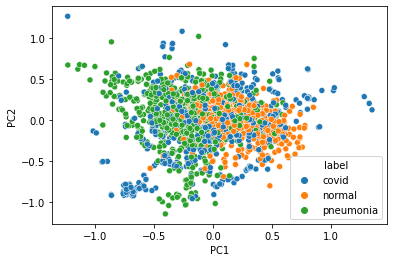

In [13]:
# plot_distributions(img_train)
calc_ANOVA(img_train)
y = []
x = [n for n in range(1, train_X.shape[1])]
for n in range(1, train_X.shape[1]):
    pca, pca_df1, test_X_PCA = calc_PCA(train_X, n, test_X)
    y.append(np.cumsum(pca.explained_variance_ratio_)[-1])
    print(np.cumsum(pca.explained_variance_ratio_))
    
# Plots the first two PCA components    
pc2, pc_df, test_X_PCA2 = calc_PCA(train_X, 2, test_X)
y_labeled = train_y.replace({0: 'normal', 1: 'pneumonia', 2: 'covid'})
plot_2d_PCA(pc_df, pd.DataFrame(y_labeled), 'label')

# Appends the four selected PCA components to the original X dataframe
# pc4, pc_df4 = calc_PCA(scaled_data, 4)
# train_X = pd.concat([train_X, pc_df4], axis=1)
train_X

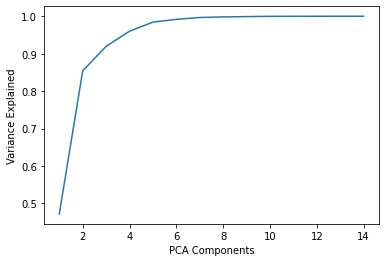

In [14]:
# Plots num of PCA components against variance explained
plt.plot(x, y)
plt.xlabel('PCA Components')
plt.ylabel('Variance Explained')
plt.show()

In [15]:
'''
Covariance and Correlation
'''
cov_matrix = np.cov(train_X.T)
correlation_matrix = train_X.corr()

for i in range(correlation_matrix.values.shape[0]):
    for j in range(correlation_matrix.values.shape[1]):
        if i != j:
            if correlation_matrix.values[i, j] > 0.9:
                print(f'There is a significant correlation ({correlation_matrix.values[i, j]}) between {train_X.columns[j]} and {train_X.columns[i]}')
                


There is a significant correlation (0.9823546280694908) between MeanAbsoluteDeviation and InterquartileRange
There is a significant correlation (0.9965791709345877) between RobustMeanAbsoluteDeviation and InterquartileRange
There is a significant correlation (0.9485477136192292) between Variance and InterquartileRange
There is a significant correlation (0.9823546280694908) between InterquartileRange and MeanAbsoluteDeviation
There is a significant correlation (0.9909223099002982) between RobustMeanAbsoluteDeviation and MeanAbsoluteDeviation
There is a significant correlation (0.9764657038232514) between Variance and MeanAbsoluteDeviation
There is a significant correlation (0.9881111169356734) between Median and Mean
There is a significant correlation (0.9924616755045834) between RootMeanSquared and Mean
There is a significant correlation (0.9881111169356734) between Mean and Median
There is a significant correlation (0.9757463979850535) between RootMeanSquared and Median
There is a sig

In [16]:
scaled_all_data.shape

(2100, 16)

KMeans model has 0.6257142857142857 accuracy
The F1 for kmeans is 0.34789100769151876
The accuracy for kmeans is 0.3742857142857143


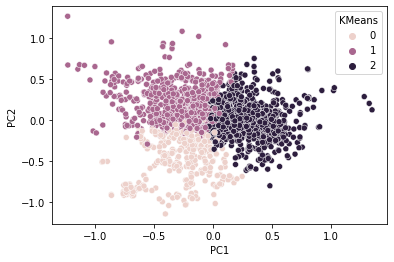

In [17]:
'''
KMeans
'''
# Fits a KMeans model with three cluster groups and appends the predicted labels to the original labels frame (for comparison)
features_to_use = ['Kurtosis', 'MeanAbsoluteDeviation', 'Mean', 'Range', 'RootMeanSquared', 'Skewness', 'TotalEnergy', 'Variance']
X_to_fit = [idx for idx in range(len(scaled_all_data.columns)) if scaled_all_data.columns[idx] in features_to_use] 
# for i in range(len(X_to_fit)):
#     X_to_fit[i] += 1
X_to_fit = [4, 6, 7, 10, 12, 13, 14, 15]
kmeans = KMeans(n_clusters=3).fit(scaled_all_data.iloc[:, X_to_fit])
df_kmeans = pd.concat([pd.DataFrame(kmeans.labels_, columns=['KMeans']), pd.DataFrame(scaled_all_data)], axis=1)
num_errors = df_kmeans[df_kmeans.label != df_kmeans.KMeans].shape[0]
accuracy = num_errors/df_kmeans.shape[0]
print(f"KMeans model has {accuracy} accuracy")


plot_2d_PCA(pc_df, pd.DataFrame(df_kmeans.KMeans), 'KMeans')

# AUC ROC
# kmeans_dummy = pd.get_dummies(pd.DataFrame(df_kmeans.iloc[:, 0]), columns=[0])
# kmeans_true = df_kmeans.iloc[:, 1]
k_labels = df_kmeans[['KMeans', 'label']]
k_accuracy = metrics.accuracy_score(k_labels.label, k_labels.KMeans, normalize=True)
f1_k = f1_score(k_labels.label, k_labels.KMeans, average='weighted')
print(f'The F1 for kmeans is {f1_k}')
print(f'The accuracy for kmeans is {k_accuracy}')

In [18]:
zeros = df_kmeans[df_kmeans.label == 0]
ones = df_kmeans[df_kmeans.label == 1]
twos = df_kmeans[df_kmeans.label == 2]

k_tp_norm = zeros[zeros.KMeans==0].shape[0]
k_fn_norm = df_kmeans[(df_kmeans.label==0) & (df_kmeans.KMeans != 0)].shape[0]
sens_k_norm = k_tp_norm/(k_tp_norm+k_fn_norm)

k_tn_norm = df_kmeans[(df_kmeans.label != 0) & (df_kmeans.KMeans != 0)].shape[0]
k_fp_norm = df_kmeans[(df_kmeans.label != 0) & (df_kmeans.KMeans == 0)].shape[0]
spec_k_norm = k_tn_norm/(k_tn_norm + k_fp_norm)
print(f'For NORMAL the sensitivity is {sens_k_norm}, specificity is {spec_k_norm}')

For NORMAL the sensitivity is 0.04285714285714286, specificity is 0.7621428571428571


In [19]:
k_tp_pneu = ones[ones.KMeans==1].shape[0]
k_fn_pneu = df_kmeans[(df_kmeans.label==1) & (df_kmeans.KMeans != 1)].shape[0]
sens_k_pneu = k_tp_pneu/(k_tp_pneu+k_fn_pneu)

k_tn_pneu = df_kmeans[(df_kmeans.label != 1) & (df_kmeans.KMeans != 1)].shape[0]
k_fp_pneu = df_kmeans[(df_kmeans.label != 1) & (df_kmeans.KMeans == 1)].shape[0]
spec_k_pneu = k_tn_pneu/(k_tn_pneu + k_fp_pneu)
spec_k_pneu
print(f'For PNEUMONIA the sensitivity is {sens_k_pneu}, specificity is {spec_k_pneu}')

For PNEUMONIA the sensitivity is 0.6214285714285714, specificity is 0.7985714285714286


In [20]:
k_tp_covid = twos[twos.KMeans==2].shape[0]
k_fn_covid = df_kmeans[(df_kmeans.label==2) & (df_kmeans.KMeans != 2)].shape[0]
sens_k_covid = k_tp_covid/(k_tp_covid+k_fn_covid)
sens_k_covid

k_tn_covid = df_kmeans[(df_kmeans.label != 2) & (df_kmeans.KMeans != 2)].shape[0]
k_fp_covid = df_kmeans[(df_kmeans.label != 2) & (df_kmeans.KMeans == 2)].shape[0]
spec_k_covid = k_tn_covid/(k_tn_covid + k_fp_covid)
print(f'For COVID the sensitivity is {sens_k_covid}, specificity is {spec_k_covid}')
spec_k_covid

For COVID the sensitivity is 0.4585714285714286, specificity is 0.5007142857142857


0.5007142857142857

In [21]:
'''
SVM
'''
# Fit an SVM using all of the features
X = train_X.iloc[:800, :]
y = train_y.iloc[:800]
m1 = SVC(C=1, kernel='linear', decision_function_shape='ovo').fit(X, y)
m1_train_preds = m1.predict(X)
m1_test_preds = m1.predict(test_X)
m1_decision = m1.decision_function(test_X)
m1_score = m1.score(test_X, test_y)
m1_f1_train = f1_score(train_y[:800], m1_train_preds, average='weighted')
m1_f1_test = f1_score(test_y, m1_test_preds, average='weighted') 

_, X2_train, X2_test = calc_PCA(train_X, 5, test_X)
X2_train = X2_train.iloc[:800, :]
m2 = SVC(C=1, kernel='linear', decision_function_shape='ovo').fit(X2_train, y)
m2_train_preds = m2.predict(X2_train)
m2_test_preds = m2.predict(X2_test)
m2_decision = m2.decision_function(X2_test)
m2_score = m2.score(X2_test, test_y)
m2_f1_train = f1_score(train_y[:800], m2_train_preds, average='weighted')
m2_f1_test = f1_score(test_y, m2_test_preds, average='weighted')
svm_labels = pd.concat([test_y, pd.DataFrame(m2_test_preds)], axis=1)
m2_accuracy = metrics.accuracy_score(svm_labels.label, svm_labels[0], normalize=True)
print(f'The F1 for SVM is {m2_f1_test}')
print(f'The accuracy for SVM is {m2_accuracy}')

The F1 for SVM is 0.7566840409050735
The accuracy for SVM is 0.76


In [22]:
svm_tp_norm = svm_labels[(svm_labels.label==0) & (svm_labels[0]==0)].shape[0]
svm_fn_norm = svm_labels[(svm_labels.label==0) & (svm_labels[0] != 0)].shape[0]
sens_svm_norm = svm_tp_norm/(svm_tp_norm + svm_fn_norm)

svm_tn_norm = svm_labels[(svm_labels.label != 0) & (svm_labels[0] != 0)].shape[0]
svm_fp_norm = svm_labels[(svm_labels.label != 0) & (svm_labels[0] == 0)].shape[0]
spec_svm_norm = svm_tn_norm/(svm_tn_norm + svm_fp_norm)

print(f'For NORMAL the sensitivity is {sens_svm_norm}, specificity is {spec_svm_norm}')

For NORMAL the sensitivity is 0.82, specificity is 0.88


In [23]:
svm_tp_pneu = svm_labels[(svm_labels.label==1) & (svm_labels[0]==1)].shape[0]
svm_fn_pneu = svm_labels[(svm_labels.label==1) & (svm_labels[0] != 1)].shape[0]
sens_svm_pneu = svm_tp_pneu/(svm_tp_pneu + svm_fn_pneu)

svm_tn_pneu = svm_labels[(svm_labels.label != 1) & (svm_labels[0] != 1)].shape[0]
svm_fp_pneu = svm_labels[(svm_labels.label != 1) & (svm_labels[0] == 1)].shape[0]
spec_svm_pneu = svm_tn_pneu/(svm_tn_pneu + svm_fp_pneu)

print(f'For PNEUMONIA the sensitivity is {sens_svm_pneu}, specificity is {spec_svm_pneu}')

For PNEUMONIA the sensitivity is 0.84, specificity is 0.85


In [24]:
svm_tp_covid = svm_labels[(svm_labels.label==2) & (svm_labels[0]==2)].shape[0]
svm_fn_covid = svm_labels[(svm_labels.label==2) & (svm_labels[0] != 2)].shape[0]
sens_svm_covid = svm_tp_covid/(svm_tp_covid + svm_fn_covid)

svm_tn_covid = svm_labels[(svm_labels.label != 2) & (svm_labels[0] != 2)].shape[0]
svm_fp_covid = svm_labels[(svm_labels.label != 2) & (svm_labels[0] == 2)].shape[0]
spec_svm_covid = svm_tn_covid/(svm_tn_covid + svm_fp_covid)

print(f'For NORMAL the sensitivity is {sens_svm_covid}, specificity is {spec_svm_covid}')

For NORMAL the sensitivity is 0.62, specificity is 0.91


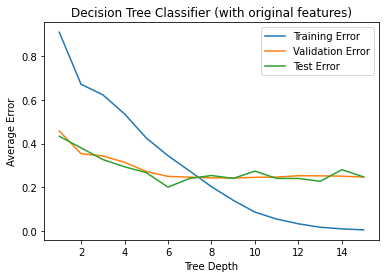

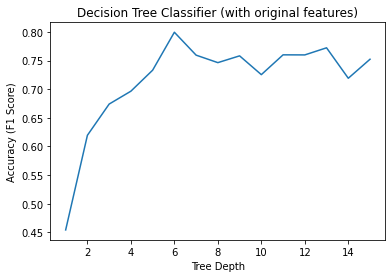

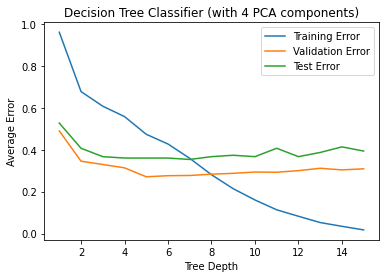

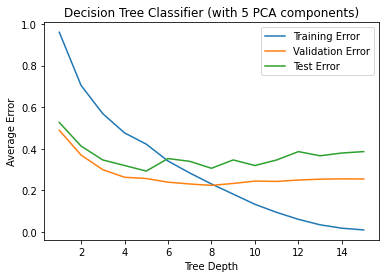

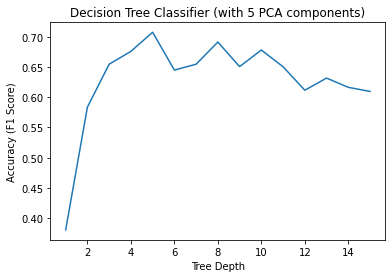

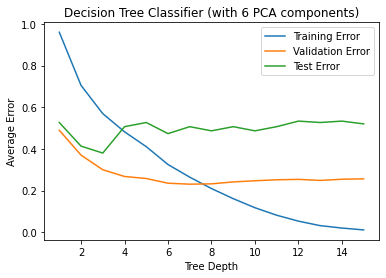

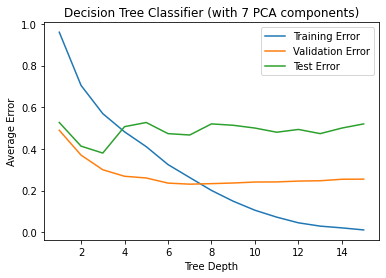

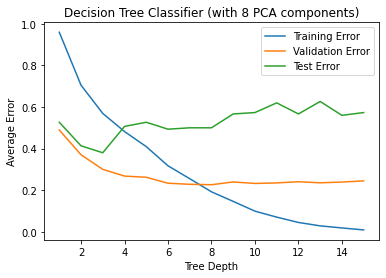

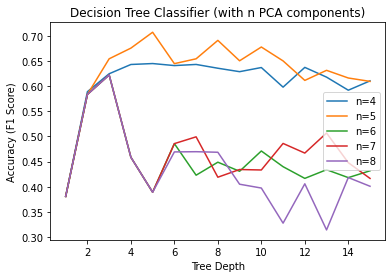

The F1 for Decision Tree is 0.7995443355015113
The accuracy for kmeans is 0.8


In [25]:
'''
Decision Tree Classifier
'''
depth = [d for d in range(1,16)]
m3_tr_error = []
m3_val_error = []
m3_te_error = []
m3_f1_scores = []
for i in range(1, 16):
    m3 = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
    m3_train_error, m3_valid_error, m3_test_error, m3_f1, m3_preds = compute_error(m3, img_train.iloc[:, :-1], img_train.iloc[:, -1], test_X, test_y)
    #     tree_train_preds = pd.DataFrame(m3.predict(train_X.iloc[:, -4:]), columns=['decision_tree'])
    m3_tr_error.append(m3_train_error)
    m3_val_error.append(m3_valid_error)
    m3_te_error.append(m3_test_error)
    m3_f1_scores.append(m3_f1)
    if i == 6:
        m3_tree6 = m3_preds
        m3_f1_final = m3_f1
        m3_accuracy = metrics.accuracy_score(test_y, m3_tree6, normalize=True)
    
# Plot train and valid error against max tree depth
plt.figure()
plt.plot(depth, m3_tr_error, label='Training Error')
plt.plot(depth, m3_val_error, label='Validation Error')
plt.plot(depth, m3_te_error, label='Test Error')
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Average Error')
plt.title('Decision Tree Classifier (with original features)')
plt.show()

plt.plot(depth, m3_f1_scores)
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy (F1 Score)')
plt.title('Decision Tree Classifier (with original features)')
plt.show()

# _, test_X_PCA = calc_PCA(test_X, 4)
# test_X = pd.concat([test_X, test_X_PCA], axis=1)
test_y = pd.DataFrame(test_y)
m4_f1_scores = []
for comp in range(4, 9):
    m4_tr_error = []
    m4_val_error = []
    m4_te_error = []
    pca_f1_scores = []
    _, train_X_PCA, test_X_PCA = calc_PCA(train_X, comp, test_X)
#     test_X_PCA = pca_gen.transform(test_X)
    for i in range(1, 16):
        m4 = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0)
        m4_train_error, m4_valid_error, m4_test_error, m4_f1, m4_preds = compute_error(m4, train_X_PCA, train_y, test_X_PCA, test_y)
        m4_tr_error.append(m4_train_error)
        m4_val_error.append(m4_valid_error)
        m4_te_error.append(m4_test_error)
        pca_f1_scores.append(m4_f1)
    m4_f1_scores.append([pca_f1_scores])
    # Plot train and valid error against max tree depth
    plt.figure()
    plt.plot(depth, m4_tr_error, label='Training Error')
    plt.plot(depth, m4_val_error, label='Validation Error')
    plt.plot(depth, m4_te_error, label='Test Error')
    plt.legend()
    plt.xlabel('Tree Depth')
    plt.ylabel('Average Error')
    plt.title(f'Decision Tree Classifier (with {comp} PCA components)')
    plt.show()
    if comp == 5:
        plt.figure()
        plt.plot(depth, pca_f1_scores)
        plt.xlabel('Tree Depth')
        plt.ylabel('Accuracy (F1 Score)')
        plt.title('Decision Tree Classifier (with 5 PCA components)')
        plt.show()
    
plt.figure()
for i in range(len(m4_f1_scores)):
    plt.plot(depth, m4_f1_scores[i][0], label=f'n={i+4}')
plt.legend()
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy (F1 Score)')
plt.title(f'Decision Tree Classifier (with n PCA components)')
plt.show()

print(f'The F1 for Decision Tree is {m3_f1_final}')
print(f'The accuracy for kmeans is {m3_accuracy}')

In [26]:
tree_labels = pd.concat([test_y, pd.DataFrame(m3_tree6)], axis=1)
tree_tp_norm = tree_labels[(tree_labels.label==0) & (tree_labels[0]==0)].shape[0]
tree_fn_norm = tree_labels[(tree_labels.label==0) & (tree_labels[0] != 0)].shape[0]
sens_tree_norm = tree_tp_norm/(tree_tp_norm + tree_fn_norm)

tree_tn_norm = tree_labels[(tree_labels.label != 0) & (tree_labels[0] != 0)].shape[0]
tree_fp_norm = tree_labels[(tree_labels.label != 0) & (tree_labels[0] == 0)].shape[0]
spec_tree_norm = tree_tn_norm/(tree_tn_norm + tree_fp_norm)

print(f'For NORMAL the sensitivity is {sens_tree_norm}, specificity is {spec_tree_norm}')

For NORMAL the sensitivity is 0.84, specificity is 0.91


In [27]:
tree_tp_pneu = tree_labels[(tree_labels.label==1) & (tree_labels[0]==1)].shape[0]
tree_fn_pneu = tree_labels[(tree_labels.label==1) & (tree_labels[0] != 1)].shape[0]
sens_tree_pneu = tree_tp_pneu/(tree_tp_pneu + tree_fn_pneu)

tree_tn_pneu = tree_labels[(tree_labels.label != 1) & (tree_labels[0] != 1)].shape[0]
tree_fp_pneu = tree_labels[(tree_labels.label != 1) & (tree_labels[0] == 1)].shape[0]
spec_tree_pneu = tree_tn_pneu/(tree_tn_pneu + tree_fp_pneu)

print(f'For NORMAL the sensitivity is {sens_tree_pneu}, specificity is {spec_tree_pneu}')

For NORMAL the sensitivity is 0.82, specificity is 0.88


In [28]:
tree_tp_covid = tree_labels[(tree_labels.label==2) & (tree_labels[0]==2)].shape[0]
tree_fn_covid = tree_labels[(tree_labels.label==2) & (tree_labels[0] != 2)].shape[0]
sens_tree_covid = tree_tp_covid/(tree_tp_covid + tree_fn_covid)

tree_tn_covid = tree_labels[(tree_labels.label != 2) & (tree_labels[0] != 2)].shape[0]
tree_fp_covid = tree_labels[(tree_labels.label != 2) & (tree_labels[0] == 2)].shape[0]
spec_tree_covid = tree_tn_covid/(tree_tn_covid + tree_fp_covid)

print(f'For NORMAL the sensitivity is {sens_tree_covid}, specificity is {spec_tree_covid}')

For NORMAL the sensitivity is 0.74, specificity is 0.91


,10Percentile,90Percentile,InterquartileRange,Kurtosis,Maximum,MeanAbsoluteDeviation,Mean,Median,Minimum,Range,RobustMeanAbsoluteDeviation,RootMeanSquared,Skewness,TotalEnergy,Variance
10Percentile,1.000000,0.486492,-0.563831,0.240226,-0.013999,-0.587328,0.884660,0.872285,0.850772,-0.522893,-0.573880,0.826086,-0.554216,0.564128,-0.585081
90Percentile,0.486492,1.000000,0.401649,-0.051754,0.632356,0.411363,0.813694,0.763922,0.251129,0.263573,0.405548,0.873966,-0.387629,0.611481,0.399044
InterquartileRange,-0.563831,0.401649,1.000000,-0.424370,0.573228,0.982355,-0.148322,-0.176742,-0.615531,0.748044,0.996579,-0.035852,0.171668,-0.038869,0.948548
Kurtosis,0.240226,-0.051754,-0.424370,1.000000,0.030651,-0.321867,0.116802,0.120517,0.049148,-0.009551,-0.402353,0.092955,-0.186034,0.105424,-0.249214
Maximum,-0.013999,0.632356,0.573228,0.030651,1.000000,0.616830,0.297466,0.238404,-0.257644,0.812169,0.576996,0.376711,0.040422,0.189751,0.592190
MeanAbsoluteDeviation,-0.587328,0.411363,0.982355,-0.321867,0.616830,1.000000,-0.163260,-0.193580,-0.660540,0.803850,0.990922,-0.046853,0.196613,-0.032037,0.976466
Mean,0.884660,0.813694,-0.148322,0.116802,0.297466,-0.163260,1.000000,0.988111,0.646163,-0.194840,-0.154148,0.992462,-0.660849,0.669772,-0.173797
Median,0.872285,0.763922,-0.176742,0.120517,0.238404,-0.193580,0.988111,1.000000,0.623577,-0.219983,-0.182524,0.975746,-0.747454,0.649310,-0.206584
Minimum,0.850772,0.251129,-0.615531,0.049148,-0.257644,-0.660540,0.646163,0.623577,1.000000,-0.772976,-0.625047,0.578270,-0.263110,0.430729,-0.639508
Range,-0.522893,0.263573,0.748044,-0.009551,0.812169,0.803850,-0.194840,-0.219983,-0.772976,1.000000,0.756264,-0.101814,0.185409,-0.135486,0.774973


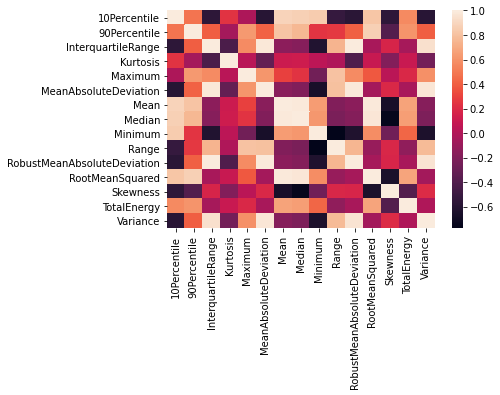

In [29]:
sns.heatmap(correlation_matrix)
correlation_matrix